In [1]:
import glob
import pandas as pd
a_p = glob.glob("otter/*")
b_p = glob.glob("seal/*")
a_t = [0] * len(a_p)
b_t = [1] * len(b_p)
df = pd.DataFrame({
    "path":a_p + b_p,
    "target":a_t + b_t
})
df

,path,target
0,otter\0.jpg,0
1,otter\1.jpg,0
2,otter\100.jpg,0
3,otter\101.jpg,0
4,otter\102.jpg,0
...,...,...
1005,seal\92.jpg,1
1006,seal\94.png,1
1007,seal\95.jpg,1
1008,seal\96.jpg,1


In [3]:
from keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import BatchNormalization
# 如果你要設置trainable與否, 一定要compile前
# CNN
for l in vgg.layers:
    l.trainable = False
# Normalize
x = BatchNormalization()(vgg.output)
# MLP
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(2, activation="softmax")(x)
model = Model(inputs=vgg.input, outputs=x)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [5]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [6]:
# 進到機器學習以後, 最好不要再出現pandas, 全部轉換nparray
import numpy as np
from sklearn.model_selection import train_test_split
x = np.array(df["path"])
y = np.array(df["target"])
result = train_test_split(x, y, test_size=0.1)
x_train, x_test, y_train, y_test = result

In [7]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(909,)
(909,)
(101,)
(101,)


In [8]:
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
from keras.preprocessing.image import load_img
from keras.applications.vgg16 import preprocess_input
def get_images(x, y, batch):
    idx = np.random.randint(0, x.shape[0], batch)
    paths = x[idx]
    
    ori_img_list = []
    img_list = []
    for p in paths:
        img = load_img(p, target_size=(224, 224)).convert("RGB")
        img = np.array(img)
        img_pre = preprocess_input(img.astype("float64"))
        ori_img_list.append(img)
        img_list.append(img_pre)
    return (np.array(ori_img_list), 
            np.array(img_list), 
            np.array(y[idx]))
        
ori, pre, target = get_images(x_train, y_train, 20)
print(ori.shape)
print(pre.shape)
print(target.shape)
# print(pre)

(20, 224, 224, 3)
(20, 224, 224, 3)
(20,)


In [9]:
TRAIN_BATCH = 20
VALIDATE_BATCH = 20

for i in range(10):
    print("-" * 15, "Epoch:", i, "-" * 15)
    _, imgs, targets = get_images(x_train, y_train, TRAIN_BATCH)
    train_result = model.train_on_batch(imgs, targets)
    print("[Train]:", train_result)
    _, imgs, targets = get_images(x_test, y_test, VALIDATE_BATCH)
    test_result = model.test_on_batch(imgs, targets)
    print("[Test]:", test_result)

--------------- Epoch: 0 ---------------

[Train]: [0.87482214, 0.55]
[Test]: [11.730359, 0.5]
--------------- Epoch: 1 ---------------
[Train]: [0.55423343, 0.9]
[Test]: [0.4433115, 0.95]
--------------- Epoch: 2 ---------------
[Train]: [0.19637212, 0.9]
[Test]: [5.045055, 0.8]
--------------- Epoch: 3 ---------------
[Train]: [2.3292823, 0.6]
[Test]: [3.1593301, 0.85]
--------------- Epoch: 4 ---------------
[Train]: [0.7550701, 0.75]
[Test]: [2.8903785, 0.9]
--------------- Epoch: 5 ---------------
[Train]: [1.3016188, 0.8]
[Test]: [2.540385, 0.95]
--------------- Epoch: 6 ---------------
[Train]: [1.1267496, 0.75]
[Test]: [1.2688161, 0.85]
--------------- Epoch: 7 ---------------
[Train]: [0.07008843, 0.95]
[Test]: [2.818901e-05, 1.0]
--------------- Epoch: 8 ---------------
[Train]: [1.50293, 0.8]
[Test]: [0.041520845, 0.95]
--------------- Epoch: 9 ---------------
[Train]: [0.010960484, 1.0]
[Test]: [3.1381168, 0.85]


In [10]:
model.predict(imgs)

array([[1.2133388e-35, 1.0000000e+00],
       [1.0000000e+00, 4.2037229e-22],
       [1.0000000e+00, 1.4629096e-17],
       [2.6773238e-05, 9.9997318e-01],
       [9.6363076e-21, 1.0000000e+00],
       [1.3455311e-27, 1.0000000e+00],
       [1.7917877e-15, 1.0000000e+00],
       [1.3887142e-12, 1.0000000e+00],
       [1.0000000e+00, 5.5567270e-27],
       [7.0534451e-26, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.1654378e-27],
       [2.1757071e-33, 1.0000000e+00],
       [3.0296546e-06, 9.9999702e-01],
       [2.9836796e-02, 9.7016317e-01],
       [4.5560061e-20, 1.0000000e+00],
       [1.0000000e+00, 2.2302053e-11],
       [1.0000000e+00, 1.1654378e-27],
       [4.4751143e-01, 5.5248851e-01],
       [1.0000000e+00, 6.2279953e-10]], dtype=float32)

In [11]:
testori, testimg, testtarget = get_images(x_test, y_test, 200)
model.evaluate(testimg, testtarget)

200/200 [==============================] - 53s 264ms/step


[0.9900593671201727, 0.9300000071525574]

In [12]:
# Model跟Sequential不一樣, 他沒有predict_classes
# predict + argmax(找到最大值的索引)來把它變成是類別
pre = model.predict(testimg)
pre

array([[1.25422925e-01, 8.74577045e-01],
       [8.52277277e-12, 1.00000000e+00],
       [1.00000000e+00, 5.12819970e-14],
       [7.05344509e-26, 1.00000000e+00],
       [1.38871423e-12, 1.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 5.43618812e-28],
       [1.06609871e-13, 1.00000000e+00],
       [9.96443808e-01, 3.55617376e-03],
       [1.25422925e-01, 8.74577045e-01],
       [1.00000000e+00, 5.55672697e-27],
       [1.00000000e+00, 6.03035006e-25],
       [1.38871423e-12, 1.00000000e+00],
       [9.99992371e-01, 7.62635000e-06],
       [1.00000000e+00, 6.03035006e-25],
       [7.05344509e-26, 1.00000000e+00],
       [1.00000000e+00, 5.11586565e-16],
       [3.06096080e-22, 1.00000000e+00],
       [3.06612862e-13, 1.00000000e+00],
       [1.00000000e+00, 1.68122960e-19],
       [7.05344509e-26, 1.00000000e+00],
       [2.98367962e-02, 9.70163167e-01],
       [1.00000000e+00, 5.12819970e-14],
       [1.00000000e+00, 2.23020526e-11],
       [1.000000

In [13]:
pre = pre.argmax(axis=1)
pre

array([1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1], dtype=int64)

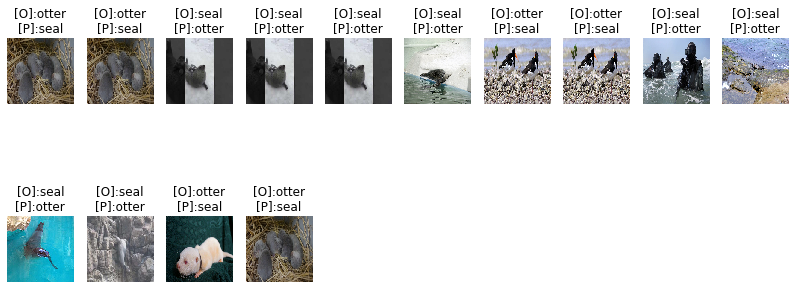

In [14]:
import matplotlib.pyplot as plt
trans = ["otter", "seal"]
# np: !=來比較每個位置的相等
# nonzero: 找到所有不為0的位置
# [類似list] -> 把所有東西一次拿給你
idx = np.nonzero(pre != testtarget)[0]

false_label = testtarget[idx]
false_pre = pre[idx]
false_img = testori[idx]

width = 10
height = len(idx) // width + 1
plt.figure(figsize=(14, 6))

false_collection = zip(false_label, false_pre, false_img)
# 得到每一個: (index, (false_label, pre, img))
for i, (l, p, img) in enumerate(false_collection):
    plt.subplot(height, width, i+1)
    t = "[O]:{}\n[P]:{}".format(trans[l], trans[p])
    plt.title(t)
    plt.axis("off")
    plt.imshow(img)